Análise do "Brazilian E-commerce Public Dataset by Olist" disponível no Kaggle. Este dataset contém informações sobre 100.000 pedidos de e-commerce no Brasil realizados entre 2016 e 2018.

Link para o dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import pandas as pd

dados = '/content/drive/MyDrive/olist'

arquivos = {
    "df_categorias": "product_category_name_translation.csv",
    "df_clientes": "olist_customers_dataset.csv",
    "df_geoloc": "olist_geolocation_dataset.csv",
    "df_pedidos": "olist_orders_dataset.csv",
    "df_itens": "olist_order_items_dataset.csv",
    "df_pagamentos": "olist_order_payments_dataset.csv",
    "df_produtos": "olist_products_dataset.csv",
    "df_reviews": "olist_order_reviews_dataset.csv",
    "df_vendedores": "olist_sellers_dataset.csv"
}

for var_name, file_name in arquivos.items():
    path = os.path.join(dados, file_name)
    globals()[var_name] = pd.read_csv(path)

    print(f"\n{var_name.upper()} ")
    globals()[var_name].info()
    print("\n Valores nulos por coluna:")
    print(globals()[var_name].isnull().sum())
    print("\nDuplicatas:", globals()[var_name].duplicated().sum())
    print("\nDescribe:", globals()[var_name].describe())




DF_CATEGORIAS 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB

 Valores nulos por coluna:
product_category_name            0
product_category_name_english    0
dtype: int64

Duplicatas: 0

Describe:        product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top             beleza_saude                 health_beauty
freq                       1                             1

DF_CLIENTES 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype

# Preparação dos Dados

### Limpeza de dados

In [7]:
df_produtos.dropna(subset=["product_category_name"], inplace=True)
df_produtos.fillna(0, inplace=True)

df_pedidos = df_pedidos[df_pedidos["order_status"] == "delivered"]
df_pedidos = df_pedidos.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"])


### Conversão de datas

In [8]:
df_pedidos["order_purchase_timestamp"] = pd.to_datetime(df_pedidos["order_purchase_timestamp"])
df_pedidos["order_approved_at"] = pd.to_datetime(df_pedidos["order_approved_at"])
df_pedidos["order_delivered_carrier_date"] = pd.to_datetime(df_pedidos["order_delivered_carrier_date"])
df_pedidos["order_delivered_customer_date"] = pd.to_datetime(df_pedidos["order_delivered_customer_date"])
df_pedidos["order_estimated_delivery_date"] = pd.to_datetime(df_pedidos["order_estimated_delivery_date"])

df_reviews["review_creation_date"] = pd.to_datetime(df_reviews["review_creation_date"])
df_reviews["review_answer_timestamp"] = pd.to_datetime(df_reviews["review_answer_timestamp"])


In [9]:
df_categorias.rename(columns={
    "product_category_name": "categoria_pt",
    "product_category_name_english": "categoria_en"
}, inplace=True)


###  Merge entre tabelas para montar um modelo relacional base

In [10]:
df_base = df_pedidos.merge(df_clientes, on="customer_id", how="left")
df_base = df_base.merge(df_itens, on="order_id", how="left")
df_base = df_base.merge(df_produtos, on="product_id", how="left")
df_base = df_base.merge(df_pagamentos, on="order_id", how="left")
df_base = df_base.merge(df_reviews, on="order_id", how="left")
df_base = df_base.merge(df_vendedores, on="seller_id", how="left")
df_base = df_base.merge(df_categorias, left_on="product_category_name", right_on="categoria_pt", how="left")


### Criar coluna de tempo de entrega

In [11]:
df_base["dias_entrega"] = (df_base["order_delivered_customer_date"] - df_base["order_purchase_timestamp"]).dt.days
df_base["dias_atraso"] = (df_base["order_delivered_customer_date"] - df_base["order_estimated_delivery_date"]).dt.days
df_base["pedido_atrasado"] = df_base["dias_atraso"].apply(lambda x: 1 if x > 0 else 0)


###  Garantir tipo correto de variáveis

In [12]:
df_produtos["product_photos_qty"] = df_produtos["product_photos_qty"].astype(int)
df_itens["order_item_id"] = df_itens["order_item_id"].astype(int)
df_pagamentos["payment_installments"] = df_pagamentos["payment_installments"].astype(int)
df_reviews["review_score"] = df_reviews["review_score"].astype(int)


# Análise Exploratória de Dados

###Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?
- O volume de pedidos apresenta uma tendência de crescimento ao longo dos meses. Observa-se um pico notável em novembro de 2017, indicando possível efeito sazonal como Black Friday.Assim, é possivel identificar indícios de sazonalidade — os pedidos aumentam em certos períodos (como fim de ano) e caem levemente em outros (como no começo do ano seguinte).

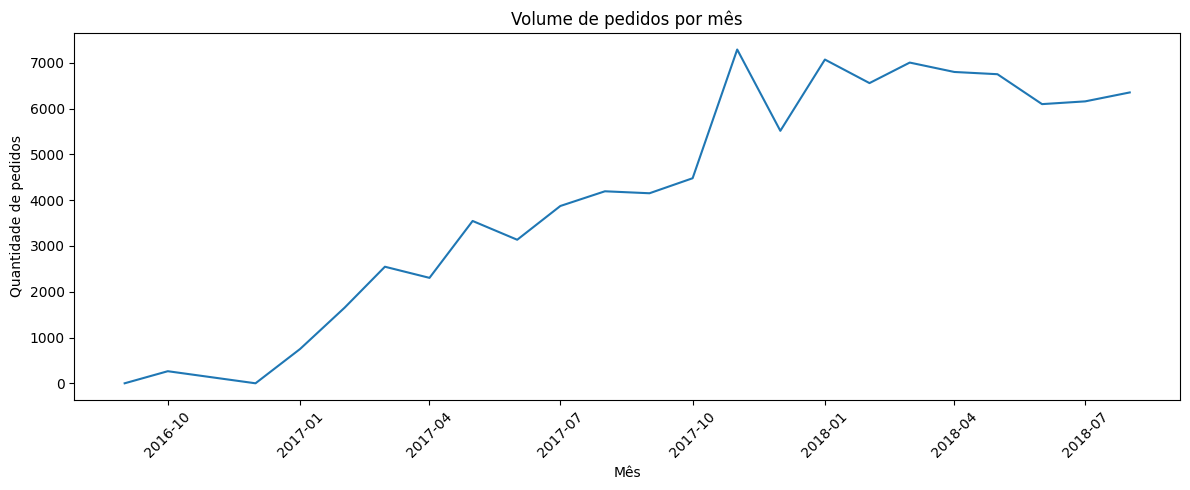

In [13]:
df_pedidos["mes_pedido"] = df_pedidos["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()
pedidos_por_mes = df_pedidos.groupby("mes_pedido").size().reset_index(name="qtd_pedidos")

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(pedidos_por_mes["mes_pedido"], pedidos_por_mes["qtd_pedidos"])
plt.title("Volume de pedidos por mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de pedidos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Qual a distribuição do tempo de entrega dos pedidos?

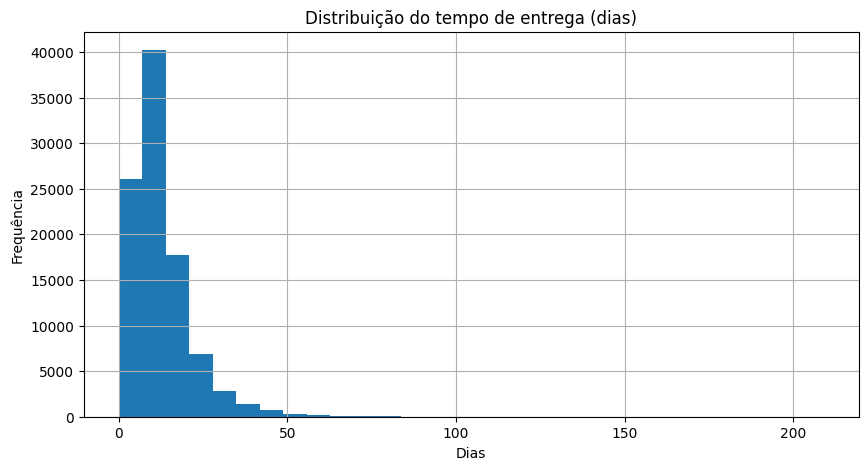

In [14]:
df_pedidos["dias_entrega"] = (df_pedidos["order_delivered_customer_date"] - df_pedidos["order_purchase_timestamp"]).dt.days
df_pedidos["dias_entrega"].hist(bins=30, figsize=(10,5))
plt.title("Distribuição do tempo de entrega (dias)")
plt.xlabel("Dias")
plt.ylabel("Frequência")
plt.show()


### Qual a relação entre o valor do frete e a distância de entrega?

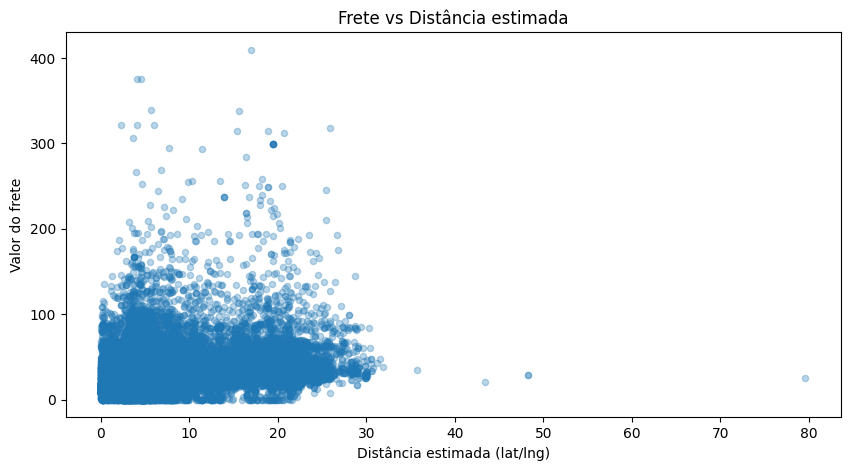

In [17]:
df_geoloc_med = df_geoloc.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

clientes_loc = df_clientes.merge(df_geoloc_med, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")
vendedores_loc = df_vendedores.merge(df_geoloc_med, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", suffixes=("_cliente", "_vendedor"))

df_dist = df_itens.merge(df_pedidos[["order_id", "customer_id"]], on="order_id")

df_dist = df_dist.merge(clientes_loc[["customer_id", "geolocation_lat", "geolocation_lng"]], on="customer_id")
df_dist = df_dist.merge(vendedores_loc[["seller_id", "geolocation_lat", "geolocation_lng"]], on="seller_id", suffixes=("_cliente", "_vendedor"))

from numpy import sqrt

df_dist["distancia"] = sqrt((df_dist["geolocation_lat_cliente"] - df_dist["geolocation_lat_vendedor"])**2 + (df_dist["geolocation_lng_cliente"] - df_dist["geolocation_lng_vendedor"])**2)

df_dist[["freight_value", "distancia"]].plot.scatter(x="distancia", y="freight_value", alpha=0.3, figsize=(10,5))
plt.title("Frete vs Distância estimada")
plt.xlabel("Distância estimada (lat/lng)")
plt.ylabel("Valor do frete")
plt.show()

### Quais são as categorias de produtos mais vendidas em termos de faturamento?

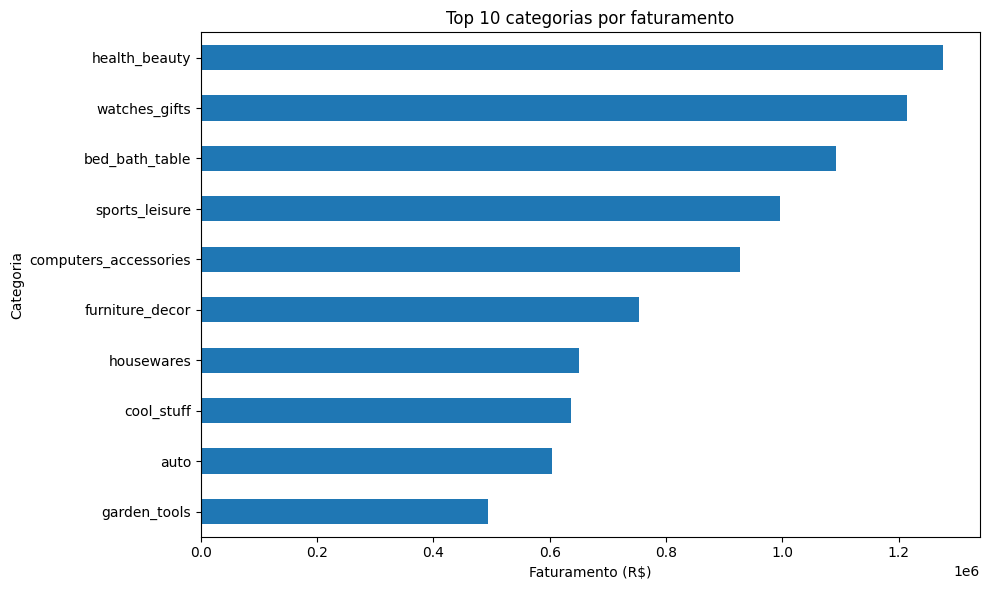

In [21]:
df_fat = df_base.groupby("categoria_en")["price"].sum().sort_values(ascending=True).tail(10)

df_fat.plot(kind="barh", figsize=(10,6))
plt.title("Top 10 categorias por faturamento")
plt.xlabel("Faturamento (R$)")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()


###  Quais estados brasileiros possuem o maior valor médio de pedido?

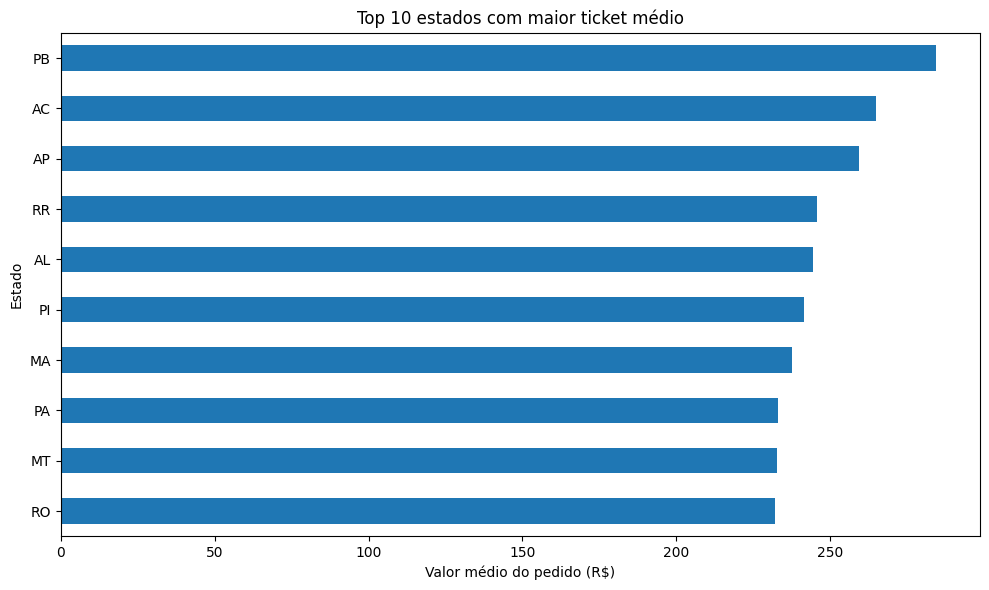

In [22]:
df_valor_pedido = df_base.groupby("customer_state")["payment_value"].mean().sort_values(ascending=True).tail(10)

df_valor_pedido.plot(kind="barh", figsize=(10,6))
plt.title("Top 10 estados com maior ticket médio")
plt.xlabel("Valor médio do pedido (R$)")
plt.ylabel("Estado")
plt.tight_layout()
plt.show()


# Solução de Problemas de Negócio

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


Análise de Retenção: Calcule a taxa de clientes recorrentes. Considere um cliente recorrente aquele que fez mais de um pedido no período analisado. Quais insights podemos extrair destes dados?

- A taxa de clientes recorrentes é baixa. Isso indica que provavelmente a maioria dos clientes compra apenas uma vez


In [23]:
clientes_freq = df_clientes.groupby("customer_unique_id")["customer_id"].nunique().reset_index()
clientes_freq.columns = ["customer_unique_id", "qtd_pedidos"]
clientes_freq["recorrente"] = clientes_freq["qtd_pedidos"] > 1

taxa_recorrentes = clientes_freq["recorrente"].mean()
print(f"Taxa de clientes recorrentes: {taxa_recorrentes:.2%}")


Taxa de clientes recorrentes: 3.12%


Predição de Atraso: Crie um modelo simples para prever se um pedido será entregue com atraso.

Defina o que seria um pedido atrasado (baseado nas colunas disponíveis)
Use os campos relevantes para criar features para seu modelo
Divida o dataset em treino e teste
Implemente um modelo de classificação simples (pode usar Regressão Logística, Random Forest ou outro de sua escolha)
Avalie a performance do modelo e explique os resultados
- O modelo consegue prever atrasos com acurácia razoável. Nesse sentidp, o recall para atrasos é importante pois foca nos casos em que o cliente pode ficar insatisfeito.

In [46]:
df_modelo = df_base.copy()
df_modelo = df_modelo.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date"])

df_modelo["dias_atraso"] = (df_modelo["order_delivered_customer_date"] - df_modelo["order_estimated_delivery_date"]).dt.days
df_modelo["atrasado"] = df_modelo["dias_atraso"].apply(lambda x: 1 if x > 0 else 0)

colunas = ["price", "freight_value", "payment_value", "payment_installments",
           "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]

df_modelo = df_modelo.dropna(subset=colunas + ["atrasado"])


In [47]:

X = df_modelo[colunas]
y = df_modelo["atrasado"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.99      0.97     32000
           1       0.54      0.15      0.24      2223

    accuracy                           0.94     34223
   macro avg       0.74      0.57      0.60     34223
weighted avg       0.92      0.94      0.92     34223



Segmentação de Clientes: Utilize técnicas de clustering para segmentar os clientes em grupos. Analise o comportamento de cada grupo e sugira estratégias de marketing específicas para cada um

- Cluster 0: Clientes novos, satisfeitos, entrega rápida.
→ Oferecer cupom de 2ª compra e campanhas de pós-venda.

- Cluster 1: Única compra, insatisfeitos, entrega muito lenta.
→ Enviar pedido de desculpas, ofertar frete rápido ou desconto.

- Cluster 2: Clientes recorrentes, satisfeitos, ticket médio estável.
→ Criar programa de fidelidade e ofertas personalizadas.

- Cluster 3: Alta compra única, satisfeitos.
→ Tratar como VIP, oferecer suporte exclusivo e frete grátis.

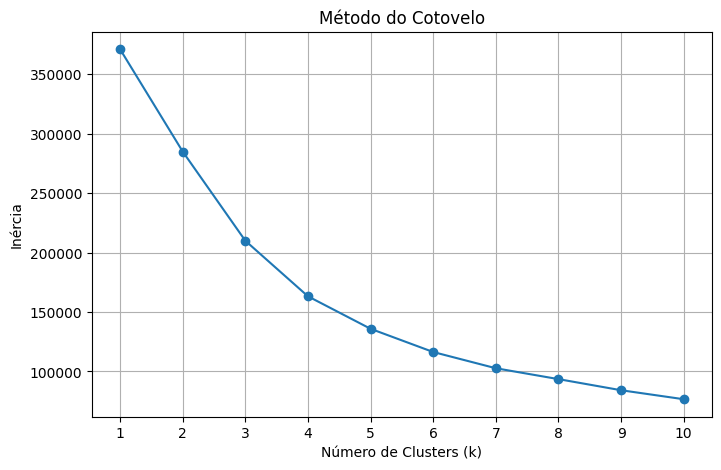

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inercia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inercia, marker='o')
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)


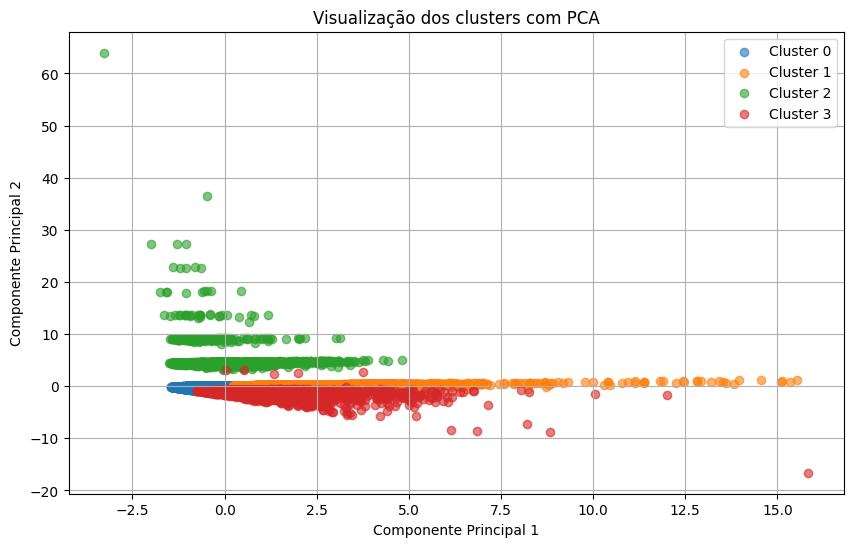

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster["pca1"] = X_pca[:, 0]
df_cluster["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10,6))
for i in range(4):
    grupo = df_cluster[df_cluster["cluster"] == i]
    plt.scatter(grupo["pca1"], grupo["pca2"], label=f"Cluster {i}", alpha=0.6)

plt.title("Visualização dos clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
resumo = df_cluster.groupby("cluster")[["qtd_pedidos", "ticket_medio", "nota_media", "entrega_media"]].mean().round(2)
print(resumo)


         qtd_pedidos  ticket_medio  nota_media  entrega_media
cluster                                                      
0               1.00        127.00        4.66          10.09
1               1.00        151.02        1.75          21.26
2               2.11        143.12        4.20          11.79
3               1.00       1108.82        4.17          13.47


Análise de Satisfação: Explore a relação entre a nota de avaliação dos clientes e diferentes aspectos como categoria do produto, tempo de entrega, valor do pedido, etc. Identifique fatores que mais impactam na satisfação do cliente.

- Tempo de entrega tem impacto direto: quanto maior o tempo, menor a nota.

- Valor do pedido não influencia fortemente a nota.

- Algumas categorias de produto são mais bem avaliadas que outras, indicando que tipo de produto e experiência impactam a satisfação.



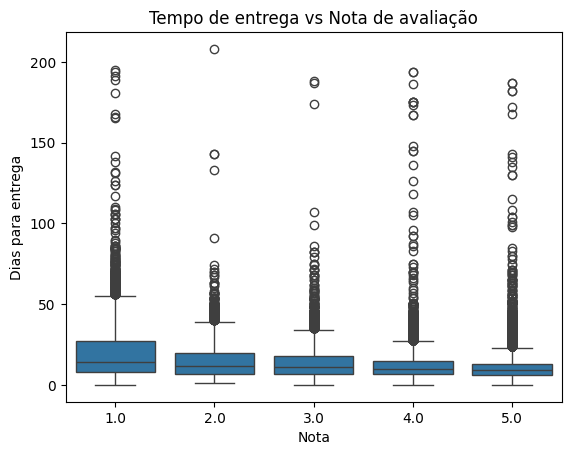

In [36]:


sns.boxplot(x="review_score", y="dias_entrega", data=df_base)
plt.title("Tempo de entrega vs Nota de avaliação")
plt.xlabel("Nota")
plt.ylabel("Dias para entrega")
plt.show()


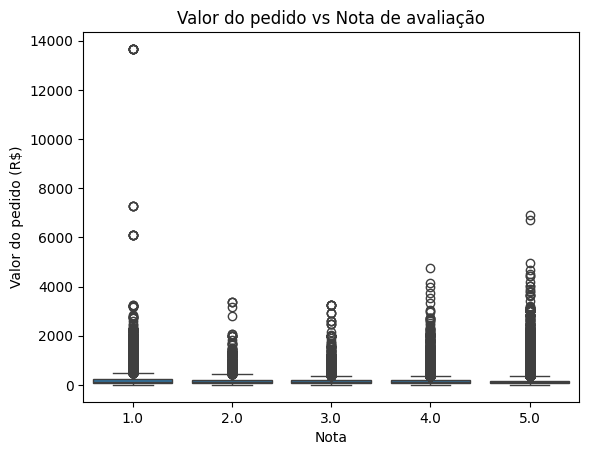

In [34]:
sns.boxplot(x="review_score", y="payment_value", data=df_base)
plt.title("Valor do pedido vs Nota de avaliação")
plt.xlabel("Nota")
plt.ylabel("Valor do pedido (R$)")
plt.show()


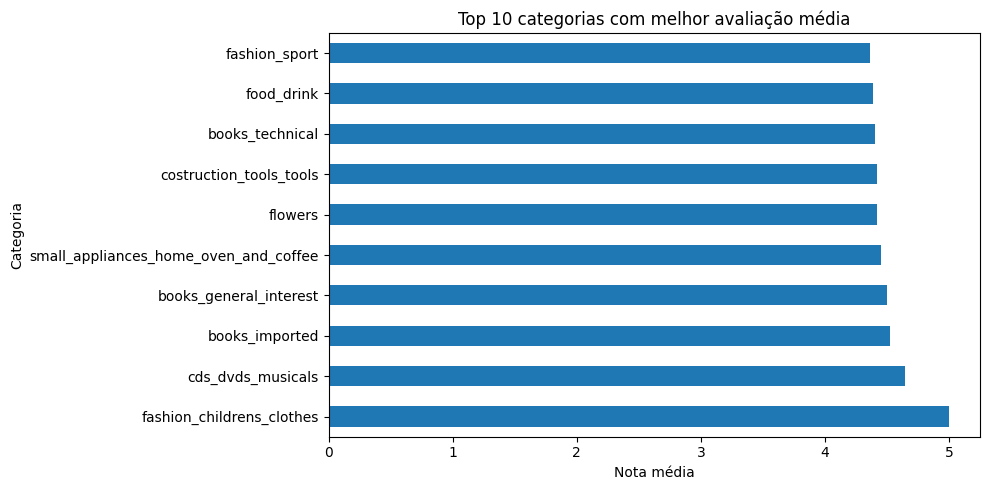

In [35]:
nota_categoria = df_base.groupby("categoria_en")["review_score"].mean().sort_values(ascending=False).head(10)

nota_categoria.plot(kind="barh", figsize=(10,5))
plt.title("Top 10 categorias com melhor avaliação média")
plt.xlabel("Nota média")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()


# Visualização e Dashboards

In [44]:
import plotly.express as px


Um dashboard geral que mostre a evolução das vendas ao longo do tempo, com filtros por estado e categoria de produto

In [43]:
df_vendas = df_base.copy()
df_vendas["mes"] = df_vendas["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

df_temp = df_vendas.groupby(["mes", "customer_state", "categoria_en"])["payment_value"].sum().reset_index()

fig = px.line(
    df_temp,
    x="mes",
    y="payment_value",
    color="categoria_en",
    facet_col="customer_state",
    facet_col_wrap=5,
    title="Evolução das Vendas por Estado e Categoria de Produto",
    labels={
        "mes": "Mês",
        "payment_value": "Faturamento (R$)",
        "categoria_en": "Categoria de Produto",
        "customer_state": "Estado"
    }
)

fig.update_layout(
    height=1000,
    legend_title="Categoria",
    title_x=0.5,
    font=dict(size=10),
    margin=dict(t=60, l=20, r=20, b=40),
    legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5)
)

fig.update_xaxes(tickangle=45, tickformat="%b\n%Y")
fig.show()


Um mapa de calor mostrando a concentração de vendas por região/estado do Brasil

In [39]:
df_estado = df_base.groupby("customer_state")["payment_value"].sum().reset_index()

fig = px.choropleth(
    df_estado,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    locations="customer_state",
    featureidkey="properties.sigla",
    color="payment_value",
    color_continuous_scale="YlOrRd",
    scope="south america",
    title="Faturamento por Estado"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


Um conjunto de gráficos que apresente a relação entre avaliação do cliente e tempo de entrega

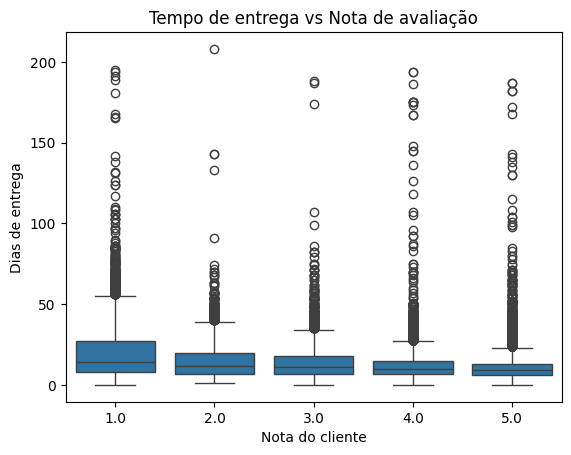

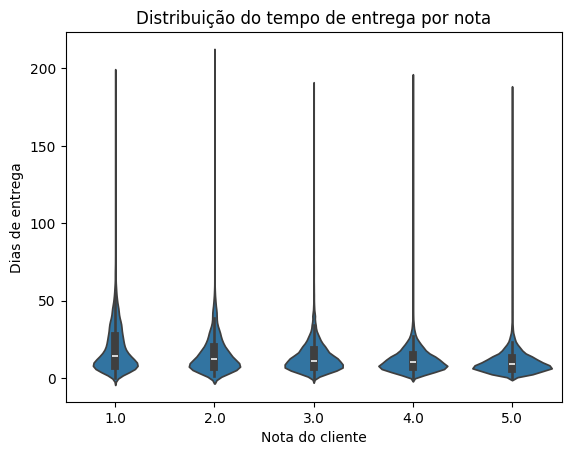

In [40]:
sns.boxplot(x="review_score", y="dias_entrega", data=df_base)
plt.title("Tempo de entrega vs Nota de avaliação")
plt.xlabel("Nota do cliente")
plt.ylabel("Dias de entrega")
plt.show()

sns.violinplot(x="review_score", y="dias_entrega", data=df_base)
plt.title("Distribuição do tempo de entrega por nota")
plt.xlabel("Nota do cliente")
plt.ylabel("Dias de entrega")
plt.show()


Um dashboard de análise dos vendedores, mostrando quais têm melhor desempenho em termos de volume de vendas, satisfação do cliente e tempo de entrega

In [52]:
df_vendedores.columns


Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [49]:
df_vendedores_agg = df_base.groupby("seller_id").agg({
    "order_id": "nunique",
    "review_score": "mean",
    "dias_entrega": "mean"
}).reset_index()

df_vendedores_agg.columns = ["seller_id", "qtd_pedidos", "nota_media", "media_entrega"]


In [53]:
import plotly.express as px

fig = px.scatter(
    df_vendedores_agg,
    x="media_entrega",
    y="nota_media",
    size="qtd_pedidos",
    hover_name="seller_id",
    title="Desempenho dos Vendedores: Entrega vs Satisfação",
    labels={
        "media_entrega": "Tempo médio de entrega (dias)",
        "nota_media": "Nota média dos clientes",
        "qtd_pedidos": "Volume de pedidos"
    }
)

fig.update_layout(height=600)
fig.show()
